In [1]:
!pip install transformers
!pip install diffusers
!pip install folium==0.9.1
!pip install huggingface-hub
!pip install pillow==9.0.0
!pip install scikit-image==0.19.2
!pip install accelerate
!pip install git+https://github.com/energy-based-model/Compositional-Visual-Generation-with-Composable-Diffusion-Models-PyTorch.git@dev
!pip install git+https://github.com/openai/glide-text2im

  Using cached Pillow-9.0.0.tar.gz (49.5 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> [24 lines of output]
      Traceback (most recent call last):
        File "/Users/deniskrylov/Developer/University/gm-project/.venv/lib/python3.13/site-packages/pip/_vendor/pyproject_hooks/_in_process/_in_process.py", line 389, in <module>
          main()
          ~~~~^^
        File "/Users/deniskrylov/Developer/University/gm-project/.venv/lib/python3.13/site-packages/pip/_vendor/pyproject_hooks/_in_process/_in_process.py", line 373, in main
          json_out["return_val"] = hook(**hook_input["kwargs"])
                                   ~~~~^^^^^^^^^^^^^^^^^^^^^^^^
        File "/Users/deniskrylov/Developer/University/gm-project/.venv/lib/python3.13/site-packages/pip/_vendor/pyproject_hooks/_in_process/_in_process.py", l

In [2]:
from google.colab import output
output.enable_custom_widget_manager()

ModuleNotFoundError: No module named 'google'

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

# **Compose Language Descriptions using pretrained Point-E (base40M-textvec)**

In [ ]:
import os
import time
import torch
import glob
import argparse
import numpy as np
import open3d as o3d
import matplotlib.pyplot as plt
import open3d.visualization.rendering as rendering

from PIL import Image
from tqdm.auto import tqdm
from point_e.diffusion.configs import DIFFUSION_CONFIGS, diffusion_from_config
from point_e.diffusion.sampler import PointCloudSampler
from point_e.models.download import load_checkpoint
from point_e.models.configs import MODEL_CONFIGS, model_from_config
from point_e.util.plotting import plot_point_cloud
from point_e.util.pc_to_mesh import marching_cubes_mesh
from point_e.util.plotting import plot_point_cloud

# create folders
plt_plot_folder = './plt_results'
mesh_folder = './mesh_results'
viewpoint_folder = './frame_results'
video_folder = './video_results'

os.makedirs(plt_plot_folder, exist_ok=True)
os.makedirs(mesh_folder, exist_ok=True)
os.makedirs(viewpoint_folder, exist_ok=True)
os.makedirs(video_folder, exist_ok=True)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print('creating base model...')
base_name = 'base40M-textvec'
base_model = model_from_config(MODEL_CONFIGS[base_name], device)
base_model.eval()
base_diffusion = diffusion_from_config(DIFFUSION_CONFIGS[base_name])

print('creating upsample model...')
upsampler_model = model_from_config(MODEL_CONFIGS['upsample'], device)
upsampler_model.eval()
upsampler_diffusion = diffusion_from_config(DIFFUSION_CONFIGS['upsample'])

print('downloading base checkpoint...')
base_model.load_state_dict(load_checkpoint(base_name, device))

print('downloading upsampler checkpoint...')
upsampler_model.load_state_dict(load_checkpoint('upsample', device))

print('creating SDF model...')
name = 'sdf'
model = model_from_config(MODEL_CONFIGS[name], device)
model.eval()

print('loading SDF model...')
model.load_state_dict(load_checkpoint(name, device))

In [ ]:
def generate_pcd(prompt_list, sampler):
    # Produce a sample from the model.
    samples = None
    for x in tqdm(sampler.sample_batch_progressive(batch_size=1, model_kwargs=dict(texts=prompt_list))):
        samples = x
    return samples


def generate_fig(samples, sampler):
    pc = sampler.output_to_point_clouds(samples)[0]
    fig = plot_point_cloud(pc, grid_size=3, fixed_bounds=((-0.75, -0.75, -0.75), (0.75, 0.75, 0.75)))
    return fig, pc


def generate_mesh(pc):
    mesh = marching_cubes_mesh(
        pc=pc,
        model=model,
        batch_size=4096,
        grid_size=128,  # increase to 128 for resolution used in evals
        progress=True,
    )
    return mesh


# generate 360 video
def generate_video(mesh_path):
    render = rendering.OffscreenRenderer(640, 480)
    mesh = o3d.io.read_triangle_mesh(mesh_path)
    mesh.compute_vertex_normals()

    mat = o3d.visualization.rendering.MaterialRecord()
    mat.shader = 'defaultLit'

    render.scene.camera.look_at([0, 0, 0], [1, 1, 1], [0, 0, 1])
    render.scene.add_geometry('mesh', mesh, mat)

    def update_geometry():
        render.scene.clear_geometry()
        render.scene.add_geometry('mesh', mesh, mat)

    def generate_images():
        for i in range(64):
            # Rotation
            R = mesh.get_rotation_matrix_from_xyz((0, 0, np.pi / 32))
            mesh.rotate(R, center=(0, 0, 0))
            # Update geometry
            update_geometry()
            img = render.render_to_image()
            o3d.io.write_image(os.path.join(viewpoint_folder, "{:05d}.jpg".format(i)), img, quality=100)
            time.sleep(0.05)

    generate_images()
    image_list = []
    for filename in sorted(glob.glob(f'{viewpoint_folder}/*.jpg')):  # assuming gif
        im = Image.open(filename)
        image_list.append(im)
    return image_list

In [ ]:
prompt = "a cake | a house" #@param{type: 'string'}
scales = "7.5 | 5.0" #@param{type: 'string'}

prompts = [x.strip() for x in prompt.split("|")]
scales = [float(x.strip()) for x in scales.split("|")]

print(prompts, scales)

sampler = PointCloudSampler(
    device=device,
    models=[base_model, upsampler_model],
    diffusions=[base_diffusion, upsampler_diffusion],
    num_points=[1024, 4096 - 1024],
    aux_channels=['R', 'G', 'B'],
    guidance_scale=[scales, 0.0],
    model_kwargs_key_filter=('texts', ''),  # Do not condition the upsampler at all
)

In [ ]:
file_name = "_".join(prompts)
pcd = generate_pcd(prompts, sampler)

# save fig visualization
fig, pc = generate_fig(pcd, sampler)
fig.show()

In [ ]:
# save mesh file
mesh = generate_mesh(pc)
mesh_path = os.path.join(mesh_folder, f'{file_name}_{scales}.ply')
with open(mesh_path, 'wb') as f:
    mesh.write_ply(f)

# generate video
image_frames = generate_video(mesh_path)
gif_path = os.path.join(video_folder, f'{file_name}.gif')
image_frames[0].save(gif_path, save_all=True, optimizer=False, duration=5, append_images=image_frames[1:], loop=0)

In [ ]:
from IPython import display

display.Image(open(gif_path, 'rb').read())

# **Compose Language Descriptions using pretrained Stable-Diffusion 1v-4**

In [2]:
import torch

from PIL import Image
from torch import autocast
from composable_stable_diffusion.pipeline_composable_stable_diffusion import ComposableStableDiffusionPipeline

has_cuda = torch.cuda.is_available()
device = torch.device('mps' if not has_cuda else 'cuda')
print(device)

# initialize stable diffusion model
pipe = ComposableStableDiffusionPipeline.from_pretrained(
    "stabilityai/stable-diffusion-2-1-base",
    use_auth_token=True
).to(device)

/Users/deniskrylov/Developer/University/gm-project/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


mps


Keyword arguments {'use_auth_token': True} are not expected by ComposableStableDiffusionPipeline and will be ignored.
Loading pipeline components...: 100%|██████████| 6/6 [00:00<00:00, 21.79it/s]
Expected types for feature_extractor: (<class 'transformers.models.clip.feature_extraction_clip.CLIPFeatureExtractor'>,), got <class 'transformers.models.clip.image_processing_clip.CLIPImageProcessor'>.


composing ['a photo of Obama', 'a photo of Biden']...


/Users/deniskrylov/Developer/University/gm-project/cvg/composable_diffusion/composable_stable_diffusion/pipeline_composable_stable_diffusion.py:501: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  num_channels_latents = self.unet.in_channels
100%|██████████| 50/50 [00:46<00:00,  1.07it/s]


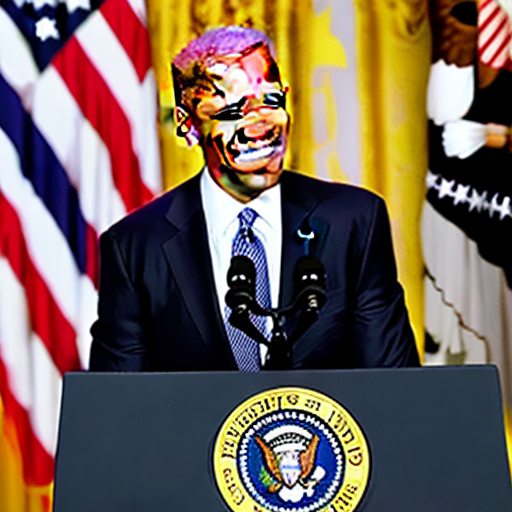

In [3]:
import torch as th
from IPython.display import display

# Sampling parameters
#@markdown Here is an example of composing sentences using conjunction operator (AND). \
#@markdown `prompt`: when composing  multiple sentences, using `|` as the delimiter.\
#@markdown `weight`: weight indicates the weight importance of sentence when composing, also using `|` as the delimiter. \
#@markdown `scale`: default weight for each prompt
prompt = "a photo of Obama | a photo of Biden" #@param{type: 'string'}
weights = "7.5 | 7.5" #@param{type: 'string'}
scale = 7.5 #@param{type: 'number'}
steps = 50 #@param{type: 'number'}
seed = 0 #@param{type: 'number'}
generator = th.Generator('mps').manual_seed(seed)

image = pipe(prompt, guidance_scale=scale, generator=generator,
              num_inference_steps=steps, weights=weights).images[0]
display(image)

composing ['A castle in a forest', 'grainy, fog']...


100%|██████████| 50/50 [00:44<00:00,  1.13it/s]


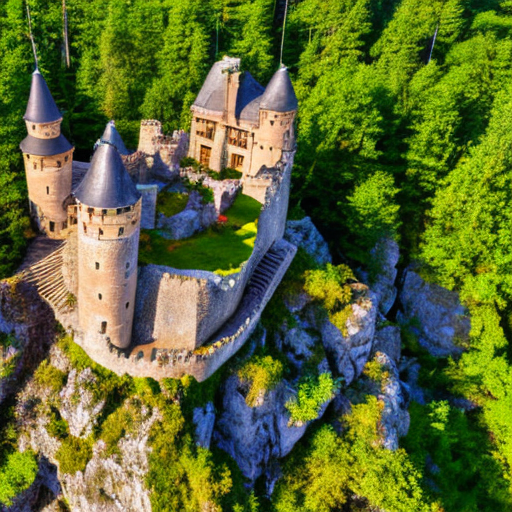

In [5]:
# Sampling parameters
#@markdown Here is an example of composing sentences using <b>Negation operator (NOT).</b> \
#@markdown <b>Negative weights should be assigned to the textes you wish to negate.</b> \
#@markdown `prompt`: when composing  multiple sentences, using `|` as the delimiter.\
#@markdown `weight`: weight indicates the weight importance of sentence when composing, also using `|` as the delimiter.
prompt = "A castle in a forest | grainy, fog" #@param{type: 'string'}
weights = "7.5 | -7.5" #@param{type: 'string'}
scale = 7.5 #@param{type: 'number'}
steps = 50 #@param{type: 'number'}
seed = 100 #@param{type: 'number'}
generator = th.Generator('mps').manual_seed(seed)

image = pipe(prompt, guidance_scale=scale, generator=generator,
              num_inference_steps=steps, weights=weights).images[0]
display(image)

# **Compose Language Descriptions using pretrained GLIDE**

In [ ]:
from PIL import Image
from IPython.display import display
import torch as th

from glide_text2im.download import load_checkpoint
from glide_text2im.model_creation import (
    create_model_and_diffusion,
    model_and_diffusion_defaults,
    model_and_diffusion_defaults_upsampler
)


In [ ]:
# This notebook supports both CPU and GPU.
# On CPU, generating one sample may take on the order of 20 minutes.
# On a GPU, it should be under a minute.

has_cuda = th.cuda.is_available()
device = th.device('cpu' if not has_cuda else 'cuda')

In [ ]:
# Create base model.
timestep_respacing =  100 #@param{type: 'number'}
options = model_and_diffusion_defaults()
options['use_fp16'] = has_cuda
options['timestep_respacing'] = str(timestep_respacing) # use 100 diffusion steps for fast sampling
model, diffusion = create_model_and_diffusion(**options)
model.eval()
if has_cuda:
    model.convert_to_fp16()
model.to(device)
model.load_state_dict(load_checkpoint('base', device))
print('total base parameters', sum(x.numel() for x in model.parameters()))

In [ ]:
# Create upsampler model.
options_up = model_and_diffusion_defaults_upsampler()
options_up['use_fp16'] = has_cuda
options_up['timestep_respacing'] = 'fast27' # use 27 diffusion steps for very fast sampling
model_up, diffusion_up = create_model_and_diffusion(**options_up)
model_up.eval()
if has_cuda:
    model_up.convert_to_fp16()
model_up.to(device)
model_up.load_state_dict(load_checkpoint('upsample', device))
print('total upsampler parameters', sum(x.numel() for x in model_up.parameters()))

In [ ]:
def show_images(batch: th.Tensor):
    """ Display a batch of images inline. """
    scaled = ((batch + 1)*127.5).round().clamp(0,255).to(th.uint8).cpu()
    reshaped = scaled.permute(2, 0, 3, 1).reshape([batch.shape[2], -1, 3])
    display(Image.fromarray(reshaped.numpy()))

In [ ]:
# Sampling parameters
#@markdown `prompt`: when composing  multiple sentences, using `|` as the delimiter.
prompt = "a camel | a forest" #@param{type: 'string'}
prompts = [x.strip() for x in prompt.split('|')]
batch_size = 1
weights = "7.5 | 7.5" #@param{type: 'string'}
weights = [float(x.strip()) for x in weights.split("|")]
print(prompts, weights)
# Tune this parameter to control the sharpness of 256x256 images.
# A value of 1.0 is sharper, but sometimes results in grainy artifacts.
upsample_temp = 0.980 #@param{type: 'number'}
assert len(prompts) == len(weights), "the number of weights specified should be the same as the number of prompts you wish to compose"
weights = th.tensor(weights).reshape(-1, 1, 1, 1).to(device)

In [ ]:
##############################
# Sample from the base model #
##############################

# sampling function
def model_fn(x_t, ts, **kwargs):
    half = x_t[:1]
    combined = th.cat([half] * x_t.size(0), dim=0)
    model_out = model(combined, ts, **kwargs)
    eps, rest = model_out[:, :3], model_out[:, 3:]
    cond_eps, uncond_eps = eps[:-1], eps[-1:]
    half_eps = uncond_eps + (weights * (cond_eps - uncond_eps)).sum(dim=0, keepdims=True)
    eps = th.cat([half_eps] * x_t.size(0), dim=0)
    return th.cat([eps, rest], dim=1)


# Create the text tokens to feed to the model.
def sample_64(prompts):
  tokens_list = [model.tokenizer.encode(prompt) for prompt in prompts]
  outputs = [model.tokenizer.padded_tokens_and_mask(
      tokens, options['text_ctx']
  ) for tokens in tokens_list]

  cond_tokens, cond_masks = zip(*outputs)
  cond_tokens, cond_masks = list(cond_tokens), list(cond_masks)

  full_batch_size = batch_size * (len(prompts) + 1)
  uncond_tokens, uncond_mask = model.tokenizer.padded_tokens_and_mask(
      [], options['text_ctx']
  )

  # Pack the tokens together into model kwargs.
  model_kwargs = dict(
      tokens=th.tensor(
          cond_tokens + [uncond_tokens], device=device
      ),
      mask=th.tensor(
          cond_masks + [uncond_mask],
          dtype=th.bool,
          device=device,
      ),
  )
  
  # Sample from the base model.
  model.del_cache()
  samples = diffusion.p_sample_loop(
      model_fn,
      (full_batch_size, 3, options["image_size"], options["image_size"]),
      device=device,
      clip_denoised=True,
      progress=True,
      model_kwargs=model_kwargs,
      cond_fn=None,
  )[:batch_size]
  model.del_cache()

  # Show the output
  return samples

In [ ]:
# sampling 64x64 images
samples = sample_64(prompts)
show_images(samples)

In [ ]:
##############################
# Upsample the 64x64 samples #
##############################

def upsampling_256(prompts, samples):
  tokens = model_up.tokenizer.encode("".join(prompts))
  tokens, mask = model_up.tokenizer.padded_tokens_and_mask(
      tokens, options_up['text_ctx']
  )

  # Create the model conditioning dict.
  model_kwargs = dict(
      # Low-res image to upsample.
      low_res=((samples+1)*127.5).round()/127.5 - 1,

      # Text tokens
      tokens=th.tensor(
          [tokens] * batch_size, device=device
      ),
      mask=th.tensor(
          [mask] * batch_size,
          dtype=th.bool,
          device=device,
      ),
  )

  # Sample from the base model.
  model_up.del_cache()
  up_shape = (batch_size, 3, options_up["image_size"], options_up["image_size"])
  up_samples = diffusion_up.ddim_sample_loop(
      model_up,
      up_shape,
      noise=th.randn(up_shape, device=device) * upsample_temp,
      device=device,
      clip_denoised=True,
      progress=True,
      model_kwargs=model_kwargs,
      cond_fn=None,
  )[:batch_size]
  model_up.del_cache()

  # Show the output
  return up_samples

In [ ]:
# upsample from 64x64 to 256x256
upsamples = upsampling_256(prompts, samples)
show_images(upsamples)

In [ ]:
# Sampling parameters
#@markdown `prompt`: when composing  multiple sentences, using `|` as the delimiter.
prompt = "A cloudy blue sky  | A mountain in the horizon | Cherry Blossoms in front of the mountain" #@param{type: 'string'}
prompts = [x.strip() for x in prompt.split('|')]
batch_size = 1
weights = "7.5 | 7.5 | 7.5" #@param{type: 'string'}
weights = [float(x.strip()) for x in weights.split("|")]
print(prompts, weights)
# Tune this parameter to control the sharpness of 256x256 images.
# A value of 1.0 is sharper, but sometimes results in grainy artifacts.
upsample_temp = 0.980 #@param{type: 'number'}
assert len(prompts) == len(weights), "the number of weights specified should be the same as the number of prompts you wish to compose"
weights = th.tensor(weights).reshape(-1, 1, 1, 1).to(device)

In [ ]:
samples = sample_64(prompts)
show_images(samples)

In [ ]:
# upsample from 64x64 to 256x256
upsamples = upsampling_256(prompts, samples)
show_images(upsamples)

# **Compose CLEVR Object at given 2D coordinates**

In [ ]:
from PIL import Image
from IPython.display import display
import torch as th

from composable_diffusion.download import download_model
from composable_diffusion.model_creation import (
    create_model_and_diffusion,
    model_and_diffusion_defaults,
    model_and_diffusion_defaults_upsampler
)

In [ ]:
has_cuda = th.cuda.is_available()
device = th.device('cpu' if not has_cuda else 'cuda')

# Create base model.
timestep_respacing =  100 #@param{type: 'number'}
options = model_and_diffusion_defaults()

flags = {
    "image_size": 128,
    "num_channels": 192,
    "num_res_blocks": 2,
    "learn_sigma": True,
    "use_scale_shift_norm": False,
    "raw_unet": True,
    "noise_schedule": "squaredcos_cap_v2",
    "rescale_learned_sigmas": False,
    "rescale_timesteps": False,
    "num_classes": '2',
    "dataset": "clevr_pos",
    "use_fp16": has_cuda,
    "timestep_respacing": str(timestep_respacing)
}

for key, val in flags.items():
  options[key] = val

model, diffusion = create_model_and_diffusion(**options)
model.eval()
if has_cuda:
    model.convert_to_fp16()
model.to(device)
model.load_state_dict(th.load(download_model('clevr_pos'), device))
print('total base parameters', sum(x.numel() for x in model.parameters()))

In [ ]:
# Sampling parameters
#@markdown `coordinates`: when composing  multiple positions, using `|` as the delimiter.
#@markdown Note: we use `x` in range `[0.1, 0.9]` and `y` in range `[0.25, 0.7]` since the training dataset labels are in given ranges.

coordinates = "0.1, 0.5 | 0.3, 0.5 | 0.5, 0.5 | 0.7, 0.5 | 0.9, 0.5" #@param{type: 'string'}
coordinates = [[float(x.split(',')[0].strip()), float(x.split(',')[1].strip())] 
               for x in coordinates.split('|')]
weights = "7.5 | 7.5 | 7.5 | 7.5 | 7.5" #@param{type: 'string'}
weights = [float(x.strip()) for x in weights.split("|")]
print(coordinates, weights)
assert len(coordinates) == len(weights), "the number of weights specified should be the same as the number of prompts you wish to compose"
weights = th.tensor(weights).reshape(-1, 1, 1, 1).to(device)

coordinates += [[-1, -1]] # add unconditional score label
batch_size = 1
# Tune this parameter to control the sharpness of 256x256 images.
# A value of 1.0 is sharper, but sometimes results in grainy artifacts.
upsample_temp = 0.980 #@param{type: 'number'}

In [ ]:
# sampling function
def model_fn(x_t, ts, **kwargs):
    half = x_t[:1]
    combined = th.cat([half] * kwargs['y'].size(0), dim=0)
    model_out = model(combined, ts, **kwargs)
    eps, rest = model_out[:, :3], model_out[:, 3:]
    cond_eps, uncond_eps = eps[:-1], eps[-1:]
    half_eps = uncond_eps + (weights * (cond_eps - uncond_eps)).sum(dim=0, keepdims=True)
    eps = th.cat([half_eps] * x_t.size(0), dim=0)
    return th.cat([eps, rest], dim=1)

In [ ]:
masks = [True] * (len(coordinates) - 1) + [False]
model_kwargs = dict(
    y=th.tensor(coordinates, dtype=th.float, device=device),
    masks=th.tensor(masks, dtype=th.bool, device=device)
)

In [ ]:
##############################
# Sample from the base model #
##############################

# Create the text tokens to feed to the model.
def sample(coordinates):
  samples = diffusion.p_sample_loop(
        model_fn,
        (len(coordinates), 3, options["image_size"], options["image_size"]),
        device=device,
        clip_denoised=True,
        progress=True,
        model_kwargs=model_kwargs,
        cond_fn=None,
    )[:batch_size]
  
  # Show the output
  return samples

In [ ]:
# sampling 128x128 images
samples = sample(coordinates)
show_images(samples)